# Data description

## Resourses

* [Dataset resourse](https://www.kaggle.com/datasets/nikitarom/planets-dataset)
* [Full descriptions of data](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data)


## File formats

* **test-jpg** - folder with jpeg tiles for test model and validate it
  
* **train-jpg** - folder with jpeg tiles for train model

* **train_classes.csv** - a list of training file names and their labels, the labels are space-delimited

* **sample_submission.csv** - correct format of submission, contains all the files in the test set. For more information about the submission file, please go to the Evaluation page



Data are set of JPG chips for reference and practice (256x256 pixels, ~947.2m x 947.2m = 897187.84 m^2 = 89.7187 Hectares = 221.7 Acres). These chips were processed using the Planet visual product processor from tiff files and then saved as jpg chips. These chips are provided as a reference to the scene content.

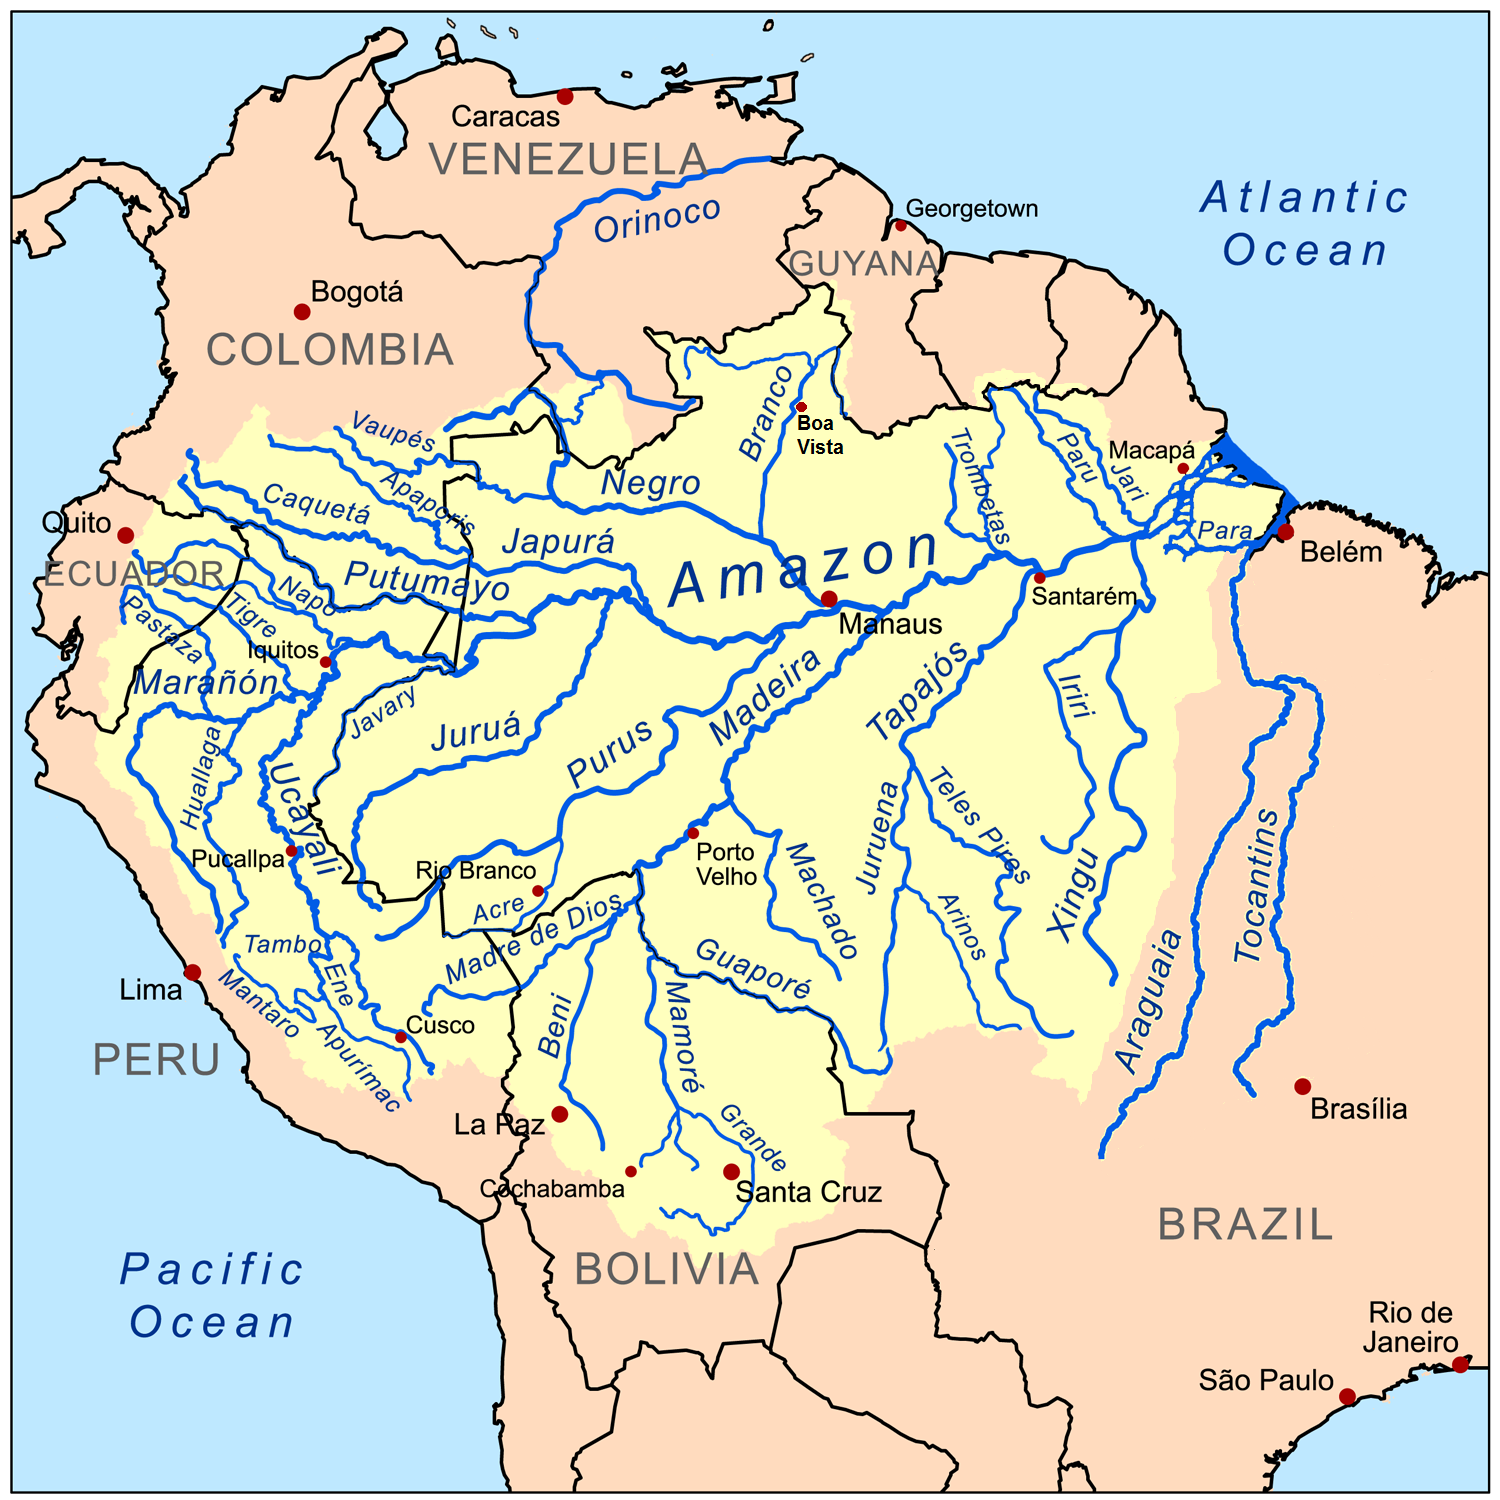

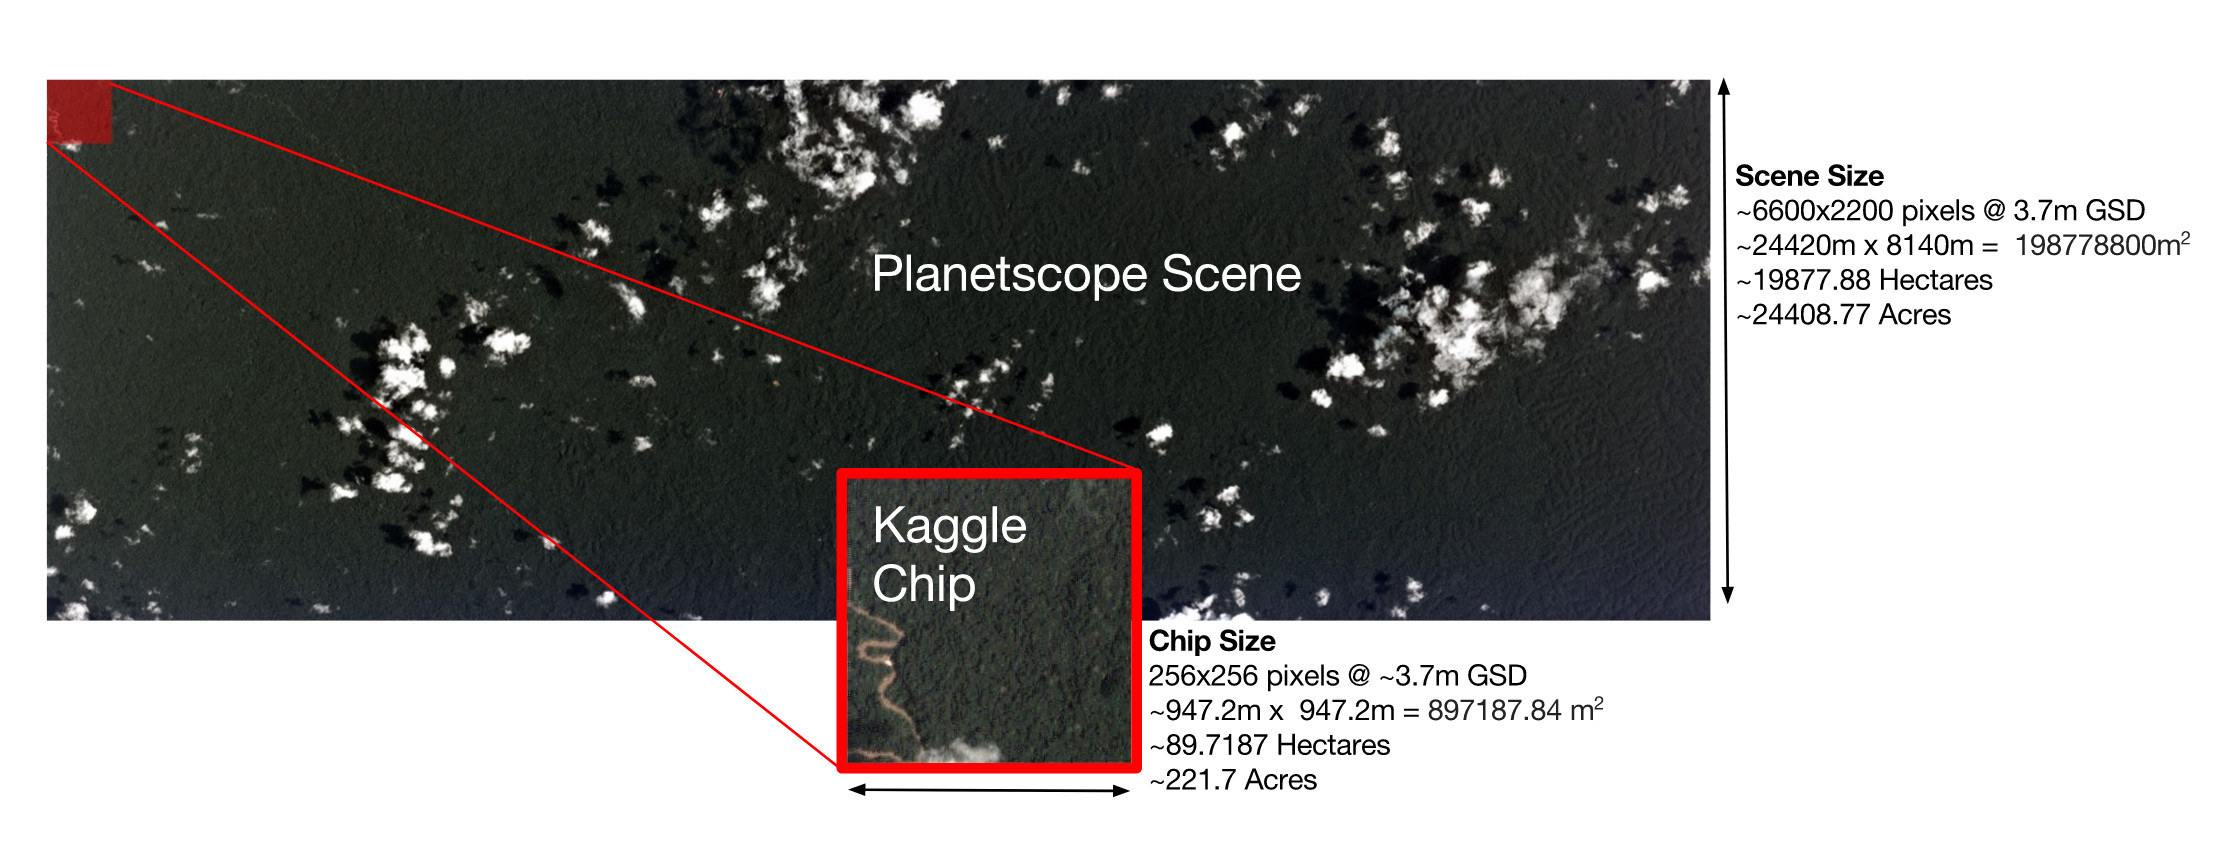


## Class Labels

The class labels for this task were chosen in collaboration with Planet's Impact team and represent a reasonable subset of phenomena of interest in the Amazon basin. The labels can broadly be broken into three groups: **atmospheric conditions, common land cover/land use phenomena, and rare land cover/land use phenomena**. Each chip will have one and potentially more than one atmospheric label and zero or more common and rare labels. Chips that are labeled as cloudy should have no other labels, but there may be labeling errors.

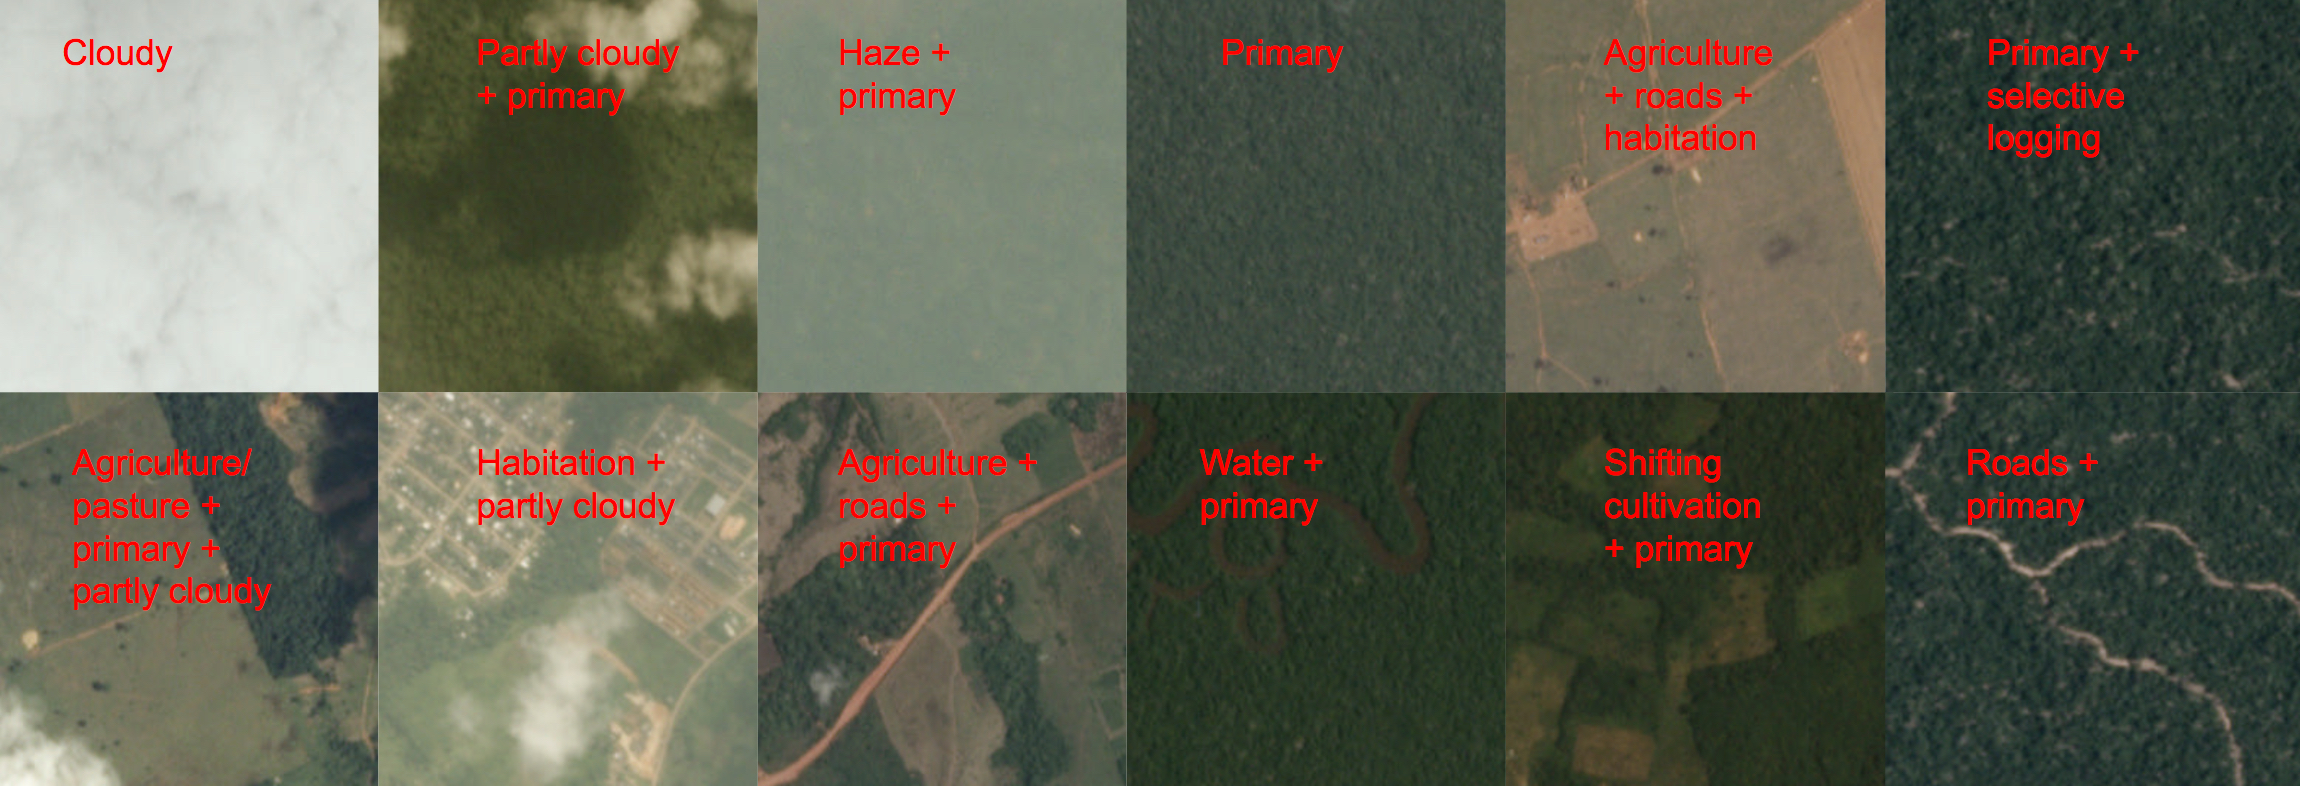

*Above: Sample chips and their labels.*


As discussed in the data collection portion of this document, the chip labels are inherently noisy due to the labeling process and ambiguity of features, and scenes may either omit class labels or have incorrect class labels. 


* **Cloud Cover Labels**: clear, partly cloudy, cloudy, and haze

* **More Common Labels**:  rainforest, agriculture, rivers, towns/cities, and roads

* **Primary Rain Forest**: The overwhelming majority of the data set is labeled as "primary", which is shorthand for primary rainforest, or what is known colloquially as virgin forest. Generally speaking, the "primary" label was used for any area that exhibited dense tree cover

* **Habitation**: The habitation class label was used for chips that appeared to contain human homes or buildings. This includes anything from dense urban centers to rural villages along the banks of rivers. Small, single-dwelling habitations are often difficult to spot but usually appear as clumps of a few pixels that are bright white.

* **Cultivation**: Shifting cultivation is a subset of agriculture that is very easy to see from space, and occurs in rural areas where individuals and families maintain farm plots for subsistence.

* **Bare Ground**: Bare ground is a catch-all term used for naturally occuring tree free areas that aren't the result of human activity. Some of these areas occur naturally in the Amazon, while others may be the result from the source scenes containing small regions of biome much similar to the pantanal or cerrado.

* **Slash and Burn**: Slash-and-burn agriculture can be considered to be a subset of the shifting cultivation label and is used for areas that demonstrate recent burn events.

* **Selective Logging**: The selective logging label is used to cover the practice of selectively removing high value tree species from the rainforest (such as teak and mahogany). From space this appears as winding dirt roads adjacent to bare brown patches in otherwise primary rain forest.

* **Blooming**: Blooming is a natural phenomenon found in the Amazon where particular species of flowering trees bloom, fruit, and flower at the same time to maximize the chances of cross pollination. These trees are quite large and these events can be seen from space.

* **Conventional Mining**: There are a number of large conventional mines in the Amazon basin and the number is steadily growning. This label is used to classify large-scale legal mining operations.

* **"Artisinal" Mining**: Artisinal mining is a catch-all term for small scale mining operations. Throughout the Amazon, especially at the foothills of the Andes, gold deposits lace the deep, clay soils. Artisanal miners, sometimes working illegally in land designated for conservation, slash through the forest and excavate deep pits near rivers. They pump a mud-water slurry into the river banks, blasting them away so that they can be processed further with mercury - which is used to separate out the gold. The denuded moonscape left behind takes centuries to recover.

* **Blow Down**: Blow down, also called windthrow, is a naturally occurring phenomenon in the Amazon. Briefly, blow down events occur during microbursts where cold dry air from the Andes settles on top of warm moist air in the rainforest. The colder air punches a hole in the moist warm layer, and sinks down with incredible force and high speed (in excess of 100MPH). These high winds topple the larger rainforest trees, and the resulting open areas are visible from space. The open areas do not stay visible for along as plants in the understory rush in to take advantage of the sunlight.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

import gc

from os import path
import sys
sys.path.append(path.abspath('..'))

In [3]:
import os
import cv2
import torch
import pandas as pd
from PIL import Image
from pprint import pprint
import albumentations as albu
from albumentations.pytorch import ToTensorV2

from src.lightning_module import PlanetsModule

## EDA

In [11]:
DATA_FOLDER = '../dataset/planet/planet/'
!ls {DATA_FOLDER}

sample_submission.csv  test-jpg  train_classes.csv  train-jpg


In [12]:
df = pd.read_csv(os.path.join(DATA_FOLDER, 'train_classes.csv'))
df.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [13]:
df.shape

(40479, 2)

In [17]:
total_tags = []
for i in range(df.shape[0]):
    for n in df['tags'][i].split(' '):
        if not n in total_tags:
            total_tags.append(n)
total_tags

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [21]:
new_df_dict = {
    'Id': []
}
for tag in total_tags:
    new_df_dict[tag] = []

for i in range(df.shape[0]):
    new_df_dict['Id'].append(df['image_name'][i])
    for n in total_tags:
        if n in df['tags'][i]:
            new_df_dict[n].append(1)
        else:
            new_df_dict[n].append(0)

new_df = df.from_dict(new_df_dict)
new_df.head()

Id  haze  primary  agriculture  clear  water  habitation  road  \
0  train_0     1        1            0      0      0           0     0   
1  train_1     0        1            1      1      1           0     0   
2  train_2     0        1            0      1      0           0     0   
3  train_3     0        1            0      1      0           0     0   
4  train_4     0        1            1      1      0           1     1   

   cultivation  slash_burn  cloudy  partly_cloudy  conventional_mine  \
0            0           0       0              0                  0   
1            0           0       0              0                  0   
2            0           0       0              0                  0   
3            0           0       0              0                  0   
4            0           0       0              0                  0   

   bare_ground  artisinal_mine  blooming  selective_logging  blow_down  
0            0               0         0                  0          0  
1            0               0         0                  0          0  
2            0               0         0                  0          0  
3            0               0         0                  0          0  
4            0               0         0                  0          0

In [22]:
new_df.shape

(40479, 18)

In [24]:
len(total_tags)

17

In [23]:
new_df.to_csv(
    os.path.join(DATA_FOLDER, 'df_train_ohe.csv'), 
    index=False
)

## Test model

In [4]:
DEVICE = 'cuda:0'

In [5]:
# Загружаем модель
checkpoints_folder = '../experiments/experiment2/'
# Берем какой-то чекпоинт из папки. Если нужен конкретный - можно явно указать путь
checkpoint_name = os.path.join(checkpoints_folder, os.listdir(checkpoints_folder)[0]) 
module = PlanetsModule.load_from_checkpoint(checkpoint_name)

module.eval()
module.to(DEVICE);

In [6]:
DATA_FOLDER = '../dataset/planet/planet/'
!ls {DATA_FOLDER}

df_test.csv   df_train_ohe.csv	sample_submission.csv  train_classes.csv
df_train.csv  df_valid.csv	test-jpg	       train-jpg


In [7]:
# Загружаем данные
df = pd.read_csv(os.path.join(DATA_FOLDER, 'df_train_ohe.csv'))
names = list(df.columns[1:])
names
df.head()

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

Id  haze  primary  agriculture  clear  water  habitation  road  \
0  train_0     1        1            0      0      0           0     0   
1  train_1     0        1            1      1      1           0     0   
2  train_2     0        1            0      1      0           0     0   
3  train_3     0        1            0      1      0           0     0   
4  train_4     0        1            1      1      0           1     1   

   cultivation  slash_burn  cloudy  partly_cloudy  conventional_mine  \
0            0           0       0              0                  0   
1            0           0       0              0                  0   
2            0           0       0              0                  0   
3            0           0       0              0                  0   
4            0           0       0              0                  0   

   bare_ground  artisinal_mine  blooming  selective_logging  blow_down  
0            0               0         0                  0          0  
1            0               0         0                  0          0  
2            0               0         0                  0          0  
3            0               0         0                  0          0  
4            0               0         0                  0          0

In [8]:
# препроцессинг данных 
img_height = 224
img_width = 224
preprocess = albu.Compose(
        [
            albu.Resize(height=img_height, width=img_width),
            albu.Normalize(),
            ToTensorV2(),
        ]
)

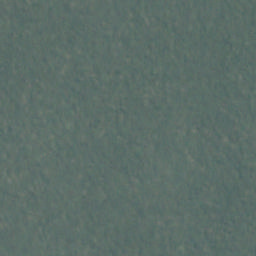

In [11]:
idx = 0
image_name = os.path.join(DATA_FOLDER, 'train-jpg', f'{df["Id"][idx]}.jpg')
image = cv2.imread(image_name)[..., ::-1]
Image.fromarray(image)

In [12]:
procecces_image = preprocess(image=image)['image']
with torch.no_grad():
    scores = torch.sigmoid(module(procecces_image[None].to(DEVICE)))[0].cpu().numpy()
    
pprint({n:s for s, n in zip(scores, names)})

{'agriculture': 0.0017112348,
 'artisinal_mine': 2.2371783e-06,
 'bare_ground': 6.254435e-05,
 'blooming': 0.001587745,
 'blow_down': 0.00020138707,
 'clear': 0.53074306,
 'cloudy': 0.0006065195,
 'conventional_mine': 5.35477e-07,
 'cultivation': 0.00046960657,
 'habitation': 0.0004968307,
 'haze': 0.44291136,
 'partly_cloudy': 0.00018077556,
 'primary': 0.9998503,
 'road': 0.00250558,
 'selective_logging': 0.00034269327,
 'slash_burn': 3.515761e-05,
 'water': 0.0013963871}
